In [41]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_17_41_cropped_1_5.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_21_22_cropped_2_1.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_18_11_cropped_3_2.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_18_11_cropped_3_0.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_01_45_cropped_5_3.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_21_46_cropped_7_5.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_17_41_cropped_1_1.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_15_39_42_cropped_6_4.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_21_46_cropped_7_1.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_09_51_cropped_0_0.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast/300x250__TS_05_08_16_17_41_cropped_1_0.jpg
/kaggle/input/graph-5/test/cyt_nep_fib_mast

In [4]:
# import os
# from PIL import Image
# from zipfile import ZipFile

# def crop_image_grid(image, crop_size=(200, 200)):
#     """Розбиває зображення на crop-и по сітці розміром crop_size"""
#     crops = []
#     width, height = image.size
#     crop_w, crop_h = crop_size

#     for top in range(0, height - crop_h + 1, crop_h):
#         for left in range(0, width - crop_w + 1, crop_w):
#             box = (left, top, left + crop_w, top + crop_h)
#             crops.append(image.crop(box))

#     return crops

# def process_images(input_path, output_path):
#     os.makedirs(output_path, exist_ok=True)

#     valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
#     image_index = 0
#     saved_count = 0

#     for root, dirs, files in os.walk(input_path):
#         for file in files:
#             ext = os.path.splitext(file)[1].lower()
#             if ext in valid_exts:
#                 input_file_path = os.path.join(root, file)

#                 # Знайти підпапку відносно input_path
#                 relative_subdir = os.path.relpath(root, input_path)
#                 output_subdir = os.path.join(output_path, relative_subdir)
#                 os.makedirs(output_subdir, exist_ok=True)

#                 try:
#                     img = Image.open(input_file_path).convert('RGB')

#                     # Збільшення в 2 рази
#                     new_size = (img.width * 2, img.height * 2)
#                     img = img.resize(new_size, Image.LANCZOS)

#                     # Сітка crop-ів
#                     crops = crop_image_grid(img, crop_size=(200, 200))
#                     base_name = os.path.splitext(file)[0]

#                     for j, crop in enumerate(crops):
#                         output_filename = f"{base_name}_cropped_{image_index}_{j}.jpg"
#                         output_file_path = os.path.join(output_subdir, output_filename)
#                         crop.save(output_file_path)
#                         saved_count += 1

#                     image_index += 1

#                 except Exception as e:
#                     print(f"❌ Помилка з {input_file_path}: {e}")

#     print(f"✅ Оброблено: {image_index} зображень, створено {saved_count} crop-ів.")

# def zip_folder(folder_path, zip_path):
#     with ZipFile(zip_path, 'w') as zipf:
#         for root, dirs, files in os.walk(folder_path):
#             for file in files:
#                 full_path = os.path.join(root, file)
#                 relative_path = os.path.relpath(full_path, folder_path)
#                 zipf.write(full_path, arcname=relative_path)
#     print(f"✅ Архів створено: {zip_path}")

# # Основний блок
# if __name__ == '__main__':
#     input_dir = '/kaggle/input/graph-4'  # ❗ Заміни на свою папку
#     output_dir = '/kaggle/working/output'
#     zip_path = '/kaggle/working/processed_images2.zip'

#     process_images(input_dir, output_dir)
#     zip_folder(output_dir, zip_path)

✅ Оброблено: 118 зображень, створено 708 crop-ів.
✅ Архів створено: /kaggle/working/processed_images2.zip


In [43]:
!pip install torch torchvision torch_geometric scikit-image networkx matplotlib --quiet


In [44]:
import os
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool

from skimage import io, segmentation, color, graph
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm import tqdm
from skimage import io, segmentation, color
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [45]:
def image_to_graph(img_path, label, img_size=(200, 200), n_segments=100):
    image = io.imread(img_path)
    image = resize(image, img_size, anti_aliasing=True)

    # Перетворення у RGB
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    # Суперпікселі
    segments = segmentation.slic(image, n_segments=n_segments, compactness=10, start_label=0)
    num_nodes = segments.max() + 1

    # Ознаки: середній RGB по кожному сегменту
    features = np.zeros((num_nodes, 3))
    for i in range(num_nodes):
        mask = segments == i
        features[i] = image[mask].mean(axis=0)

    # Граф суміжності регіонів
    rag = graph.rag_mean_color(image, segments, mode='distance')
    edge_list = list(rag.edges())

    if len(edge_list) == 0:
        # Якщо немає ребер — створимо петлі на кожен вузол (самозв'язок)
        edge_index = torch.arange(0, num_nodes, dtype=torch.long).repeat(2, 1)
    else:
        edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    # PyTorch Geometric Data
    x = torch.tensor(features, dtype=torch.float)
    y = torch.tensor([label], dtype=torch.long)

    return Data(x=x, edge_index=edge_index, y=y)

In [46]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curve(model, loader, num_classes, device):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            y_scores.append(out.cpu())
            y_true.append(data.y.cpu())

    y_scores = torch.cat(y_scores).numpy()
    y_true = torch.cat(y_true).numpy()

    if num_classes == 2:
        # Бінарна класифікація
        y_true_bin = label_binarize(y_true, classes=[0, 1])
        score = y_scores[:, 1] if y_scores.shape[1] > 1 else y_scores.ravel()

        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Binary)")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    else:
        # Мультикласова класифікація
        y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

        plt.figure(figsize=(8, 6))
        for i in range(num_classes):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Multiclass)")
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, loader, class_names, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            y_true.append(data.y.cpu())
            y_pred.append(pred.cpu())

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.grid(False)
    plt.show()

In [48]:
# Приклад структури: dataset/
# ├── class_0/
# │   ├── img1.jpg
# │   └── ...
# ├── class_1/
# │   ├── img2.jpg

root_dir = '/kaggle/input/graph-5/train/'  # <- Змініть на свій шлях
graph_list = []

class_map = {cls: idx for idx, cls in enumerate(os.listdir(root_dir))}
for cls_name in class_map:
    class_path = os.path.join(root_dir, cls_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        data = image_to_graph(img_path, label=class_map[cls_name])
        graph_list.append(data)

train_loader = DataLoader(graph_list, batch_size=8, shuffle=True)

In [49]:
class GNN(torch.nn.Module):
    def __init__(self, input_dim=3, hidden_dim=200, output_dim=2):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.classifier(x)
    

In [50]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN(output_dim=len(class_map)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()
for epoch in range(1, 251):
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch}, Loss: {total_loss:.4f}')

Epoch 1, Loss: 85.7679
Epoch 2, Loss: 82.4617
Epoch 3, Loss: 78.5401
Epoch 4, Loss: 70.8638
Epoch 5, Loss: 66.7394
Epoch 6, Loss: 60.3883
Epoch 7, Loss: 57.4357
Epoch 8, Loss: 53.8805
Epoch 9, Loss: 51.8094
Epoch 10, Loss: 49.9266
Epoch 11, Loss: 47.2703
Epoch 12, Loss: 46.2953
Epoch 13, Loss: 47.9494
Epoch 14, Loss: 45.8753
Epoch 15, Loss: 44.7357
Epoch 16, Loss: 46.0690
Epoch 17, Loss: 41.5693
Epoch 18, Loss: 41.6653
Epoch 19, Loss: 42.3203
Epoch 20, Loss: 38.8062
Epoch 21, Loss: 39.4836
Epoch 22, Loss: 38.2312
Epoch 23, Loss: 39.6529
Epoch 24, Loss: 37.5803
Epoch 25, Loss: 38.0093
Epoch 26, Loss: 36.2555
Epoch 27, Loss: 36.3021
Epoch 28, Loss: 36.6871
Epoch 29, Loss: 33.8738
Epoch 30, Loss: 35.9952
Epoch 31, Loss: 33.1907
Epoch 32, Loss: 32.9369
Epoch 33, Loss: 32.3299
Epoch 34, Loss: 34.2229
Epoch 35, Loss: 31.7549
Epoch 36, Loss: 31.3837
Epoch 37, Loss: 30.3454
Epoch 38, Loss: 29.7105
Epoch 39, Loss: 30.3681
Epoch 40, Loss: 29.1906
Epoch 41, Loss: 27.2888
Epoch 42, Loss: 27.6151
E

In [52]:
model.eval()
correct = 0
for data in train_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
print(f'Accuracy: {correct / len(graph_list):.4f}')

Accuracy: 0.9535


In [22]:
############################
############################
##########################
#########################
root_dir = '/kaggle/input/graph-5/test/'  # <- Змініть на свій шлях
graph_list = []

class_map = {cls: idx for idx, cls in enumerate(os.listdir(root_dir))}
for cls_name in class_map:
    class_path = os.path.join(root_dir, cls_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        data = image_to_graph(img_path, label=class_map[cls_name])
        graph_list.append(data)

test_loader = DataLoader(graph_list, batch_size=8, shuffle=True)

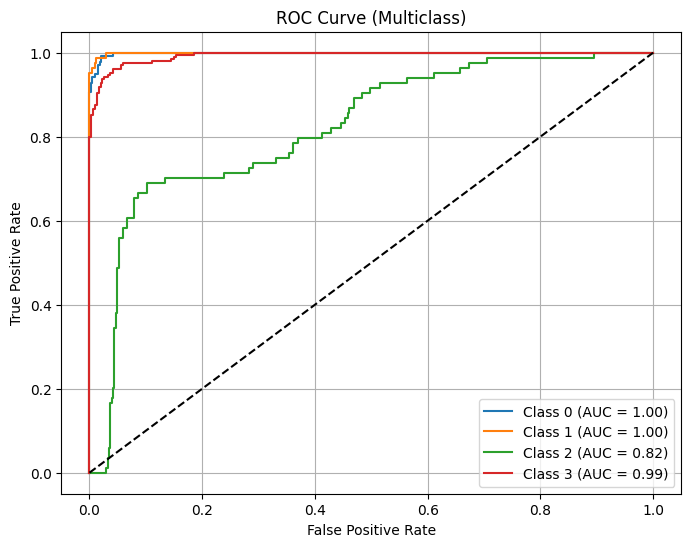

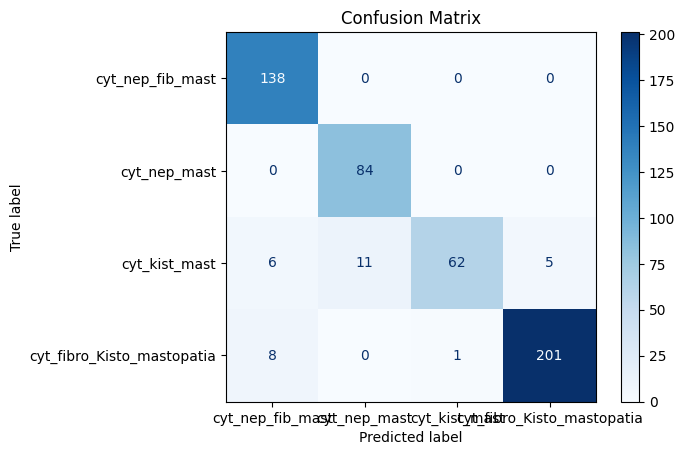

In [24]:
num_classes = len(class_map)
class_names = list(class_map.keys())

plot_roc_curve(model, train_loader, num_classes=len(class_map), device=device)
plot_confusion_matrix(model, train_loader, class_names, device)

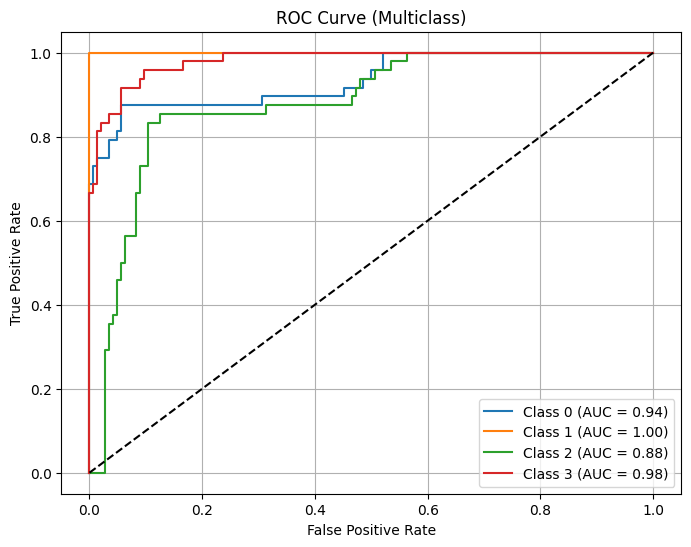

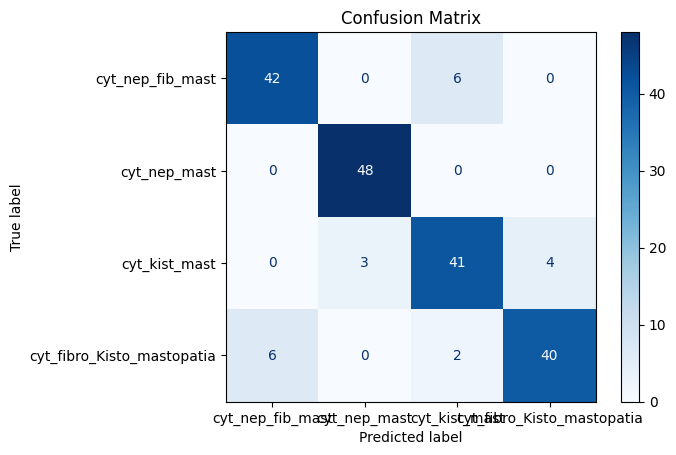

In [25]:
num_classes = len(class_map)
class_names = list(class_map.keys())

plot_roc_curve(model, test_loader, num_classes=len(class_map), device=device)
plot_confusion_matrix(model, test_loader, class_names, device)


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

model.eval()
all_preds = []
all_labels = []

for data in train_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)

    # Збір усіх предиктів і справжніх міток
    all_preds.extend(pred.cpu().numpy())
    all_labels.extend(data.y.cpu().numpy())

# Метрики
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-score:  {f1:.4f}')

Accuracy:  0.9399
Precision: 0.9380
Recall:    0.9238
F1-score:  0.9250


In [216]:
model.eval()
correct = 0
for data in test_loader:
    data = data.to(device)
    out = model(data)
    pred = out.argmax(dim=1)
    correct += int((pred == data.y).sum())
print(f'Accuracy: {correct / len(graph_list):.4f}')

Accuracy: 0.8125


In [192]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_graph_on_image(img_path, graph_data, img_size=(64, 64), segments_n=100):
    # Завантаження та ресайз
    image = io.imread(img_path)
    image = resize(image, img_size, anti_aliasing=True)

    # Гарантоване RGB
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    # Сегментація
    segments = segmentation.slic(image, n_segments=segments_n, compactness=10, start_label=0)
    num_nodes = segments.max() + 1

    # Обчислення центрів суперпікселів (для розміщення вузлів)
    coords = np.zeros((num_nodes, 2))  # (y, x)
    for i in range(num_nodes):
        mask = segments == i
        y, x = np.nonzero(mask)
        coords[i] = [y.mean(), x.mean()]  # у пікселях

    # Побудова графа з edge_index
    G = nx.Graph()
    edge_index = graph_data.edge_index.cpu().numpy().T
    G.add_edges_from(edge_index)

    # Візуалізація
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    pos = {i: (coords[i][1], coords[i][0]) for i in range(num_nodes)}  # x, y
    nx.draw(G, pos=pos, node_color='red', node_size=30, edge_color='yellow', width=1.5)
    plt.title("Graph Overlay on Image")
    plt.axis('off')
    plt.show()

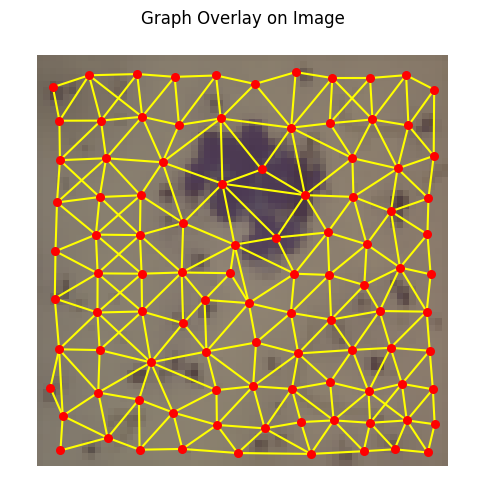

In [72]:
example_data = image_to_graph('/kaggle/input/graph-2/class_0/300x250__TS_05_08_16_39_29.bmp', label=0)
visualize_graph_on_image('/kaggle/input/graph-2/class_0/300x250__TS_05_08_16_39_29.bmp', example_data)

In [108]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GATConv, global_mean_pool

class GATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1):
        super(GATClassifier, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads, concat=True)
        self.gat2 = GATConv(hidden_channels * heads, hidden_channels, heads=1, concat=True)
        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, x, edge_index, batch=None):
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))

        if batch is None:
            # Якщо не переданий batch (наприклад, при explain_graph), створюємо його як усі нулі
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [75]:
def get_attention_weights(model, data, layer=1):
    model.eval()
    data = data.to(next(model.parameters()).device)

    with torch.no_grad():
        if layer == 1:
            _, (edge_index, attn_weights) = model.gat1(data.x, data.edge_index, return_attention_weights=True)
        elif layer == 2:
            x = F.relu(model.gat1(data.x, data.edge_index))
            _, (edge_index, attn_weights) = model.gat2(x, data.edge_index, return_attention_weights=True)
        else:
            raise ValueError("layer must be 1 or 2")
    
    return edge_index.cpu().numpy(), attn_weights.cpu().numpy()

In [80]:
def visualize_attention(img_path, data, edge_index, attn_weights, img_size=(64, 64)):
    image = io.imread(img_path)
    image = resize(image, img_size, anti_aliasing=True)
    # Перетворення у RGB
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    
        
    segments = segmentation.slic(image, n_segments=data.x.shape[0], compactness=10, start_label=0)

    # Центри вузлів
    coords = np.zeros((data.x.shape[0], 2))
    for i in range(data.x.shape[0]):
        mask = segments == i
        y, x = np.nonzero(mask)
        coords[i] = [y.mean(), x.mean()]

    # Побудова графа
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    # Візуалізація
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    pos = {i: (coords[i][1], coords[i][0]) for i in range(len(coords))}

    # Масштабування ваг
    edge_weights = attn_weights * 5.0

    nx.draw(G, pos=pos, node_size=30, edge_color=edge_weights, edge_cmap=plt.cm.plasma, width=2)
    plt.title("Graph Attention Weights (GAT)")
    plt.axis('off')
    plt.show()

In [81]:
model = GATClassifier(in_channels=3, hidden_channels=64, out_channels=2).to(device)
data = image_to_graph('/kaggle/input/graph-2/class_0/300x250__TS_05_08_16_39_29.bmp', label=0)
edge_idx, attn = get_attention_weights(model, data)
visualize_attention('/kaggle/input/graph-2/class_0/300x250__TS_05_08_16_39_29.bmp', data, edge_idx, attn)

AttributeError: 'GlobalStorage' object has no attribute 'ndim'

In [98]:
from torch_geometric.explain import Explainer
from torch_geometric.explain.algorithm import GNNExplainer

def create_explainer(model, task_level='graph', return_type='log_probs', epochs=100):
    explainer = Explainer(
        model=model,
        algorithm=GNNExplainer(epochs=epochs),
        explanation_type='model',       # пояснити висновок моделі
        node_mask_type=None,           # або 'attributes', якщо хочемо node feature пояснення
        edge_mask_type='object',       # пояснення по ребрах
        model_config=dict(
            mode='multiclass_classification',
            task_level=task_level,
            return_type=return_type,
        ),
        # threshold_config={'threshold_type': 'topk', 'value': 10},  # опційно для top-k ребер
    )
    return explainer

In [111]:
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GATConv, global_mean_pool

class MultiHeadGATClassifier(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads1=4, heads2=6, dropout=0.6):
        super(MultiHeadGATClassifier, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads1, concat=True, dropout=dropout)
        # Другий шар агрегація без конкатенації, щоб зменшити розмірність
        self.gat2 = GATConv(hidden_channels * heads1, hidden_channels, heads=heads2, concat=False, dropout=dropout)
        self.fc = nn.Linear(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index, batch=None):
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.elu(self.gat2(x, edge_index))

        if batch is None:
            batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)

        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x

In [113]:
model = MultiHeadGATClassifier(in_channels=3, hidden_channels=8, out_channels=2, heads1=4, heads2=6, dropout=0.6).to(device)

# Подаємо на вхід
out = model(data.x, data.edge_index, data.batch)

In [114]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from tqdm import tqdm

def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in tqdm(loader):
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)
        loss = F.cross_entropy(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        pred = out.argmax(dim=1)
        correct += (pred == data.y).sum().item()
        total += data.num_graphs
    return correct / total

In [115]:
def get_attention_weights(model, data):
    model.eval()
    with torch.no_grad():
        # В виклику GATConv можна отримати увагу, якщо встановити return_attention_weights=True
        # Але у PyG це робиться окремим методом
        # Тому тут виконаємо окремий крок

        # Перший GAT шар:
        out, (edge_index, attn_weights) = model.gat1(data.x, data.edge_index, return_attention_weights=True)
        # attn_weights shape: [num_edges, heads]

        # Агрегуємо увагу по головах (середнє)
        attn_weights_mean = attn_weights.mean(dim=1).cpu().numpy()

    return edge_index.cpu().numpy(), attn_weights_mean

In [116]:
import matplotlib.pyplot as plt
import networkx as nx
from skimage import io
from skimage.transform import resize
from skimage.segmentation import slic

def visualize_attention(img_path, data, edge_index, attn_weights, img_size=(64,64), top_k=20):
    # Завантажуємо і ресайзимо зображення
    image = io.imread(img_path)
    image = resize(image, img_size, anti_aliasing=True)
    if image.ndim == 2:
        image = np.stack([image]*3, axis=-1)
    elif image.shape[2] == 4:
        image = image[:, :, :3]

    # Сегментація суперпікселів
    segments = slic(image, n_segments=data.x.shape[0], compactness=10, start_label=0)

    # Центри суперпікселів (вузлів)
    coords = np.zeros((data.x.shape[0], 2))
    for i in range(data.x.shape[0]):
        mask = segments == i
        y, x = np.nonzero(mask)
        coords[i] = [y.mean(), x.mean()]

    # Побудова графа
    G = nx.Graph()
    G.add_edges_from(edge_index.T)

    # Вибираємо top_k ребер з найбільшим attention
    top_indices = attn_weights.argsort()[-top_k:]
    top_edge_index = edge_index[:, top_indices]
    top_attn = attn_weights[top_indices]

    # Позиції для візуалізації
    pos = {i: (coords[i][1], coords[i][0]) for i in range(len(coords))}

    plt.figure(figsize=(8,8))
    plt.imshow(image)
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color='cyan', alpha=0.6)
    # Рисуємо лише ребра з топ увагою, товщина залежить від ваги
    edges_to_draw = [(int(u), int(v)) for u,v in zip(top_edge_index[0], top_edge_index[1])]
    weights = (top_attn - top_attn.min()) / (top_attn.max() - top_attn.min() + 1e-8) * 3 + 0.5  # нормалізація товщини
    nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, width=weights, edge_color='red', alpha=0.8)
    plt.axis('off')
    plt.title("Top Attention Edges on Image Superpixels")
    plt.show()

In [117]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiHeadGATClassifier(in_channels=3, hidden_channels=8, out_channels=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Припустимо, у тебе є DataLoader
train_loader = DataLoader(graph_list, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Навчання (кілька епох)
for epoch in range(1, 21):
    loss = train(model, train_loader, optimizer, device)
    acc = evaluate(model, val_loader, device)
    print(f"Epoch {epoch:02d}, Loss: {loss:.4f}, Val Acc: {acc:.4f}")

# Візуалізація уваги для одного прикладу
sample_data = val_dataset[0]
edge_index, attn_weights = get_attention_weights(model, sample_data.to(device))
visualize_attention('/kaggle/input/graph-2/class_0/300x250__TS_05_08_16_39_29.bmp', sample_data, edge_index, attn_weights)

NameError: name 'train_dataset' is not defined

In [30]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 🧩 Конфігурація
architecture = 'lenet'  # або 'mobilenet' чи 'lenet'
batch_size = 32
num_epochs = 75
learning_rate = 1e-3

# 📁 Шляхи
train_dir = '/kaggle/input/graph-4/cytology_xmass_07_01_22_1/train'  # 🔁 Заміни на свою назву
test_dir = '/kaggle/input/graph-4/cytology_xmass_07_01_22_1/test'

# 🔁 Трансформації
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 📦 Завантаження датасетів
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = len(train_dataset.classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 🧠 Модель LeNet
class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Flatten(),
            nn.Linear(16 * 53 * 53, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# 🧠 Вибір моделі
def get_model(name, num_classes):
    if name == 'alexnet':
        model = models.alexnet(pretrained=False)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
    elif name == 'mobilenet':
        model = models.mobilenet_v2(pretrained=False)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif name == 'lenet':
        model = LeNet(num_classes)
    else:
        raise ValueError("Unknown model architecture")
    return model.to(device)

# 🔧 Ініціалізація
model = get_model(architecture, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 🏋️‍♂️ Навчання
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs} — Loss: {avg_loss:.4f}")

# 📊 Оцінка
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 📈 Метрики
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print("\n📊 Evaluation on TEST set:")
print(f'Accuracy:  {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall:    {recall:.4f}')
print(f'F1-score:  {f1:.4f}')
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=train_dataset.classes, zero_division=0))

Epoch 1/75 — Loss: 1.3793
Epoch 2/75 — Loss: 1.3248
Epoch 3/75 — Loss: 1.2345
Epoch 4/75 — Loss: 1.2230
Epoch 5/75 — Loss: 1.1230
Epoch 6/75 — Loss: 1.0003
Epoch 7/75 — Loss: 0.8886
Epoch 8/75 — Loss: 0.7027
Epoch 9/75 — Loss: 0.6636
Epoch 10/75 — Loss: 0.6288
Epoch 11/75 — Loss: 0.4805
Epoch 12/75 — Loss: 0.3989
Epoch 13/75 — Loss: 0.4312
Epoch 14/75 — Loss: 0.3166
Epoch 15/75 — Loss: 0.3635
Epoch 16/75 — Loss: 0.4056
Epoch 17/75 — Loss: 0.4541
Epoch 18/75 — Loss: 0.2585
Epoch 19/75 — Loss: 0.3492
Epoch 20/75 — Loss: 0.3458
Epoch 21/75 — Loss: 0.3152
Epoch 22/75 — Loss: 0.1836
Epoch 23/75 — Loss: 0.2144
Epoch 24/75 — Loss: 0.2458
Epoch 25/75 — Loss: 0.1836
Epoch 26/75 — Loss: 0.1613
Epoch 27/75 — Loss: 0.1070
Epoch 28/75 — Loss: 0.1199
Epoch 29/75 — Loss: 0.0715
Epoch 30/75 — Loss: 0.0760
Epoch 31/75 — Loss: 0.0514
Epoch 32/75 — Loss: 0.0497
Epoch 33/75 — Loss: 0.0358
Epoch 34/75 — Loss: 0.0320
Epoch 35/75 — Loss: 0.0319
Epoch 36/75 — Loss: 0.0173
Epoch 37/75 — Loss: 0.0241
Epoch 38/7

In [33]:
import torch

if torch.cuda.is_available():
    print(f"🔋 CUDA доступна")
    print(f"🖥️ Назва GPU: {torch.cuda.get_device_name(0)}")
    print(f"📦 Пам'ять (МБ): {torch.cuda.get_device_properties(0).total_memory // 1024 ** 2}")
    print(f"🧠 Кількість GPU: {torch.cuda.device_count()}")
else:
    print("❌ CUDA не доступна")

❌ CUDA не доступна
